In [183]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [29]:
# Read in all dataframes
dfs = []
k = 0
for f in os.scandir("./coords"):
    if f.is_file() and f.name != '.DS_Store':
        df = pd.read_csv(f)
        df['class'] = k
        dfs.append(df)
        k += 1
        
dfs[0].head()

,score,nose_score,leftEye_score,rightEye_score,leftEar_score,rightEar_score,leftShoulder_score,rightShoulder_score,leftElbow_score,rightElbow_score,...,rightHip_x,leftKnee_y,leftKnee_x,rightKnee_y,rightKnee_x,leftAnkle_y,leftAnkle_x,rightAnkle_y,rightAnkle_x,class
0,0.565957,0.999123,0.998200,0.996400,0.924315,0.947072,0.957494,0.947747,0.062188,0.152223,...,183.242909,415.273558,215.838174,366.027177,160.726307,527.887454,206.924328,505.618097,131.604030,0
1,0.545799,0.990537,0.991718,0.992416,0.585613,0.289436,0.821773,0.936248,0.396081,0.026364,...,210.280452,478.801242,238.659256,441.879988,143.778982,580.143367,233.357855,505.307716,211.428675,0
2,0.657214,0.998008,0.990955,0.986429,0.671019,0.248268,0.966711,0.986788,0.902529,0.033043,...,299.850258,314.979777,419.893105,349.013720,323.449590,301.494596,337.986366,446.779468,341.193836,0
3,0.588887,0.990551,0.998967,0.999236,0.588298,0.714369,0.787232,0.810225,0.863416,0.685289,...,1023.983170,649.718255,1305.485842,749.196573,1068.610535,686.690766,1214.431514,910.851472,1102.573775,0
4,0.780212,0.998642,0.986117,0.996111,0.916750,0.888298,0.915750,0.875743,0.984774,0.833988,...,141.234296,197.203453,228.542591,236.904748,150.821788,208.283654,167.932071,320.456794,167.368610,0


In [45]:
combined_dfs = pd.concat(dfs, ignore_index=True)

In [74]:
# Create ground truth y
y = []

# Grab every possible combination of 2 rows
for index in list(combinations(combined_dfs.index,2)):
    y.append(int(combined_dfs['class'][index[0]] == combined_dfs['class'][index[1]]))

In [173]:
def scale_transform_normalize(coords):
    """
    Parameters:
    coords (df): dataframe of (x,y) coordinates

    Returns:
    df: coords scaled to 1x1 with center at (0,0)
    """
    x_cols = [col for col in coords if col.endswith('x')]
    y_cols = [col for col in coords if col.endswith('y')]
    x_diff = coords[x_cols].max(axis=1) - coords[x_cols].min(axis=1)
    y_diff = coords[y_cols].max(axis=1) - coords[y_cols].min(axis=1)
    diff_max = pd.concat([x_diff, y_diff], axis=1).max(axis=1)

    coords[x_cols] = coords[x_cols].subtract(coords[x_cols].mean(axis=1), axis=0)\
                                   .div(diff_max, axis=0)
    coords[y_cols] = coords[y_cols].subtract(coords[y_cols].mean(axis=1), axis=0)\
                                   .div(diff_max, axis=0)
    coords.div(coords.pow(2, axis=1).sum(axis=1), axis=0)

    coords = coords.fillna(0)
    return coords

In [174]:
# Scale, transform, normalize vectors
filter_col = [col for col in combined_dfs if col.endswith('x') or col.endswith('y')]
coords = combined_dfs[filter_col]
coords = scale_transform_normalize(coords)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [176]:
# Get y_pred
y_pred = []

# Grab every possible combination of 2 rows
for index in list(combinations(coords.index,2)):
    vec_1 = coords.loc[index[0]].values.reshape((1,34))
    vec_2 = coords.loc[index[1]].values.reshape((1,34))
    cosine_score = cosine_similarity(vec_1, vec_2)[0]
    y_pred.append(cosine_score)

AUC: 0.712


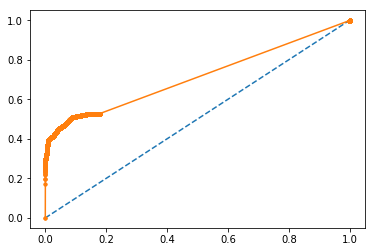

In [180]:
# Check ROC, AUC
fpr, tpr, thresholds = roc_curve(y, y_pred)
auc = roc_auc_score(y, y_pred)
print('AUC: %.3f' % auc)

# Plot
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [182]:
print(thresholds)

[ 2.          1.          1.         ... -0.81224168 -0.8272259
 -0.84649041]
